### File Explanation

**preprocessData.ipynb:**
<br> This notebook is to process AddNeuroMed data from 'loadData.pickle' and generate examples for the network

**Processes are as follows:**
<br> 1) Load all variables from 'loadData.pickle'
<br> 2) Retrieve a snapshot of rSnp_nSN and rRna_nSR to observe the density (location: **3rd cell**)
<br> 3) Create "sGenePairs_lG" to be used in the next step by using "nPairs_lRlN"
<br> 4) Sort gene pairs based on TF Entrez ID (function: **sort_Gene_Pairs** in **preprocessData_utils.py**)
<br> 5) Divide training and test data such that no direct or indirect correlation exists (function: **train_Test_Data** in **preprocessData_utils.py**)
<br> 6) Check if there exists a shared gene between training and test data (location: **5th cell**)
<br> 7) Generate samples for +1, -1, and 0 labelled examples (function: **buildSamples**)
<br> 8) Save them in "preprocessData.pickle" format to be called by "trainRNN.ipynb"

**Some abbreviations used:**
<br> **S:** number of subjects 
<br> **R:** number of transcripts
<br> **N:** number of SNPs
<br> **C:** number of label categories
<br> **X:** number of examples

**Variables created:**
<br> 1) **rSnpA_nXSN**: SNP encodings of gene A, NumPy array, shape of (X, S, N)
<br> 2) **rSnpB_nXSN**: SNP encodings of gene B, NumPy array, shape of (X, S, N)
<br> 3) **rRnaA_nXS**: Gene expression of gene A, NumPy array, shape of (X, S)
<br> 4) **rRnaB_nXS**: Gene expression of gene B, NumPy array, shape of (X, S)
<br> 5) **rRelated_nXC**: Labels of examples, NumPy array, shape of (X, C)
<br> 6) **rSnpA_tr_nXSN**: SNP encodings of gene A in training data, NumPy array, shape of (X, S, N)
<br> 7) **rSnpB_tr_nXSN**: SNP encodings of gene B in training data, NumPy array, shape of (X, S, N)
<br> 8) **rRnaA_tr_nXS**: Gene expression of gene A in training data, NumPy array, shape of (X, S)
<br> 9) **rRnaB_tr_nXS**: Gene expression of gene B in training data, NumPy array, shape of (X, S)
<br> 10) **rRelated_tr_nXC**: Labels of examples in training data, NumPy array, shape of (X, C)
<br> 11) **rSnpA_tst_nXSN**: SNP encodings of gene A in test data, NumPy array, shape of (X, S, N)
<br> 12) **rSnpB_tst_nXSN**: SNP encodings of gene B in test data, NumPy array, shape of (X, S, N)
<br> 13) **rRnaA_tst_nXS**: Gene expression of gene A in test data, NumPy array, shape of (X, S)
<br> 14) **rRnaB_tst_nXS**: Gene expression of gene B in test data, NumPy array, shape of (X, S)
<br> 15) **rRelated_tst_nXC**: Labels of examples in test data, NumPy array, shape of (X, C)
<br> 16) **sGeneNames_nX2**: Gene names, NumPy array, shape of (X, 2)
<br> 17) **nRs**: Transcript names, NumPy array, shape of (R, 1)
<br> 18) **nSs**: Subject names, NumPy array, shape of (S, 1)

In [14]:
# Set up environment variables for rpy2 to work
import os
os.environ['R_HOME'] = '/anaconda3/envs/tensorflow/lib/R'
os.environ['R_USER'] = '/anaconda3/envs/tensorflow/lib/python3.6/site-packages/rpy2'

os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [2]:
# LOAD DATA
# Load data form the pickle produced by "loadData_v4.ipsynb"

# Save data into Python friendly file
import pickle
with open( 'loadData.pickle', 'rb' ) as f:
    rRna_nSR = pickle.load( f )
    sDem_nSD = pickle.load( f )
    rSnp_nSN = pickle.load( f )
    sGenesAD_nG = pickle.load( f )
    nNs_lRlN = pickle.load( f )
    nPairs_lPlC = pickle.load( f )
    nSs = pickle.load( f )
    nRs = pickle.load( f )
    nDs = pickle.load( f )
    nNs = pickle.load( f )
    
# Transform lists into numpies for convenience
import numpy as np
nSs = np.array( nSs ) # Subject names
nRs = np.array( nRs ) # Rna names
nDs = np.array( nDs ) # Demographic features names
nNs = np.array( nNs ) # Snp names
sGenesAD_nG = np.vectorize( lambda nG : 'rna' + nG )( sGenesAD_nG )

# Check if there are 0s / missing information in rSnp_nSN and replace them with the most common allele
rSnp_nSN[ rSnp_nSN == 0 ] = 3
bCheck = (0 in rSnp_nSN)
assert(bCheck == False)
print("Missing values in rSnp_nSN are replaced with 3")

# Check input
assert( len( nSs ) > 200 ) # len(nSs) = 206
assert( len( nRs ) > 500 ) # len(nRs) = 957
assert( len( nDs ) > 10 ) # len( nDs ) = 25
assert( len( nNs ) > 500 ) # len( nNs ) = 163142
assert( len( nRs ) == len( nNs_lRlN ) ) # len( nRs ) = 957
assert( len( nRs ) >= len( sGenesAD_nG ) )
print( 'Data loaded from pickles.' )
print( 'Number of subjects iSnum: {}'.format( len( nSs ) ) )
print( 'Number of transcripts iRnum: {}'.format( len( nRs ) ) )
print( 'Number of SNPs iNnum: {}'.format( len( nNs ) ) )
print( 'Number of demographics iDnum: {}'.format( len( nDs ) ) )
print( 'Number of paired genes: {}'.format ( len(nPairs_lPlC[0] ) ) )

Missing values in rSnp_nSN are replaced with 3
Data loaded from pickles.
Number of subjects iSnum: 206
Number of transcripts iRnum: 957
Number of SNPs iNnum: 163142
Number of demographics iDnum: 25
Number of paired genes: 2204


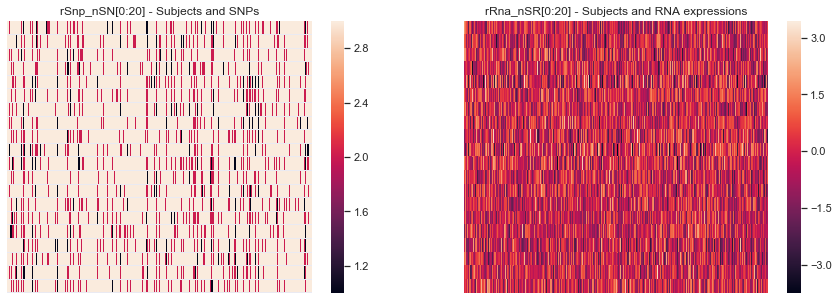

In [18]:
np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

width = 15
height = 5
plt.figure( figsize = ( width, height ) )

plt.subplot(1, 2, 1)
sns.heatmap(rSnp_nSN[0:20], xticklabels=False, yticklabels=False)
plt.title("rSnp_nSN[0:20] - Subjects and SNPs")

plt.subplot(1, 2, 2)
sns.heatmap(rRna_nSR[0:20], xticklabels=False, yticklabels=False)
plt.title("rRna_nSR[0:20] - Subjects and RNA expressions")
plt.show()


In [4]:
%run preprocessData_utils.py

# Get gene pairs in more efficient format
sGenePairs_lG = [[ str( "rna" ) + nPairs_lPlC[1][i], str( "rna" ) + nPairs_lPlC[3][i] ] 
                     for i in range( len( nPairs_lPlC[0] ) ) ]

# Divide training and testing data
sGenePairs_tr_nG, sGenePairs_tst_nG, sGenePairs_tr_lG, sGenePairs_tst_lG = train_Test_Data( sGenePairs_lG )

In [6]:
# Check if there is a shared gene between training and testing data
sSortedGenePairs_nG = sort_Gene_Pairs( sGenePairs_lG=sGenePairs_lG )

nGenes_tr_0 = np.unique( sGenePairs_tr_nG[ :, 0 ] )
nGenes_tr_1 = np.unique( sGenePairs_tr_nG[ :, 1 ] )
nGenes_tst_0 = np.unique( sGenePairs_tst_nG[ :, 0 ] )
nGenes_tst_1 = np.unique( sGenePairs_tst_nG[ :, 1 ] )
nGenes_0 = np.unique( sSortedGenePairs_nG[ :, 0 ] )
nGenes_1 = np.unique( sSortedGenePairs_nG[ :, 1 ] )

uniqueGenes = np.unique( sSortedGenePairs_nG )

nGenes_tr = np.unique( sGenePairs_tr_nG )
nGenes_tst = np.unique( sGenePairs_tst_nG )

print("TF difference: {}".format( len( nGenes_tst_0 ) + len( nGenes_tr_0 ) - len( nGenes_0 ) ) )

print("")
print("Target difference: {}".format( len( nGenes_tr_1 ) + len( nGenes_tst_1 ) - len( nGenes_1 ) ) )


print("")
print("Overall difference: {}".format( len( nGenes_tr ) + len( nGenes_tst ) - len( uniqueGenes ) ) )

TF difference: 0

Target difference: 0

Overall difference: 0


In [10]:
# BUILD SAMPLES
# From the loaded data, create samples with the format that can be directly read by NNs
%run preprocessData_utils.py

def buildSamples( nNs_lRlN, 
                  rSnp_nSN, 
                  rRna_nSR,
                  sGenePairs_lG,
                  nNs,
                  nRs, 
                  iXnum,
                  iNmax = 100):
    """ 
    Builds samples for the neural networks. 
    These samples consist of two inputs, one with the SNPs, other one with gene expression levels.
    Samples belong to either of three classes. 
    
    Arguments:
    nNs_lRlN = Correspondence between SNP names and transcripts, list, length of (R)
    rSnp_nSN = SNP values per subject with respect to each snp name, numpy array of shape (S, N)
    rRna_nSR = The value of rna levels per subject and gene, numpy array of shape (S, R)
    nNs = SNP names (N)
    nRs = Transcript names (R)
    iNmax = Maximum number of SNP, (100)
    iXnum = Number of samples, (500)
    
    Returns:
    rSnp_nXSN = The first input to the neural network, containing the SNP values per subject, NumPy array, shape of (X, S, N)
    rRna_nXS = The second input to the neural network, containing the gene expression, NumPy array, shape of (X, S)
    rRelated_nXC = Outputs for the neural network. C corresponds to class. C = 1 when genes affect in right order, 
                                                                           C = -1 when genes affect in the opposite order, 
                                                                           C = 0 when genes do not affect, NumPy array, shape of (X, C)
    """
    
    # Check inputs
    assert( iXnum < len( nRs ) )
    assert( rSnp_nSN.shape[0] == rRna_nSR.shape[0] )
    
    # Create hashed dictionary to access the "N" dimension of quickly
    import numpy as np
    print2F( 'Generating hashed index for SNPs' )
    iNs_dN = dict( zip( [nNs[i] for i in range( len( nNs ) )], [i for i in range( len( nNs ) )] ) ) # Dictionary (snp names: indexes)
    iNad_1_nN = [ iNs_dN[ nN ] for nN in nNs_lRlN[10] ] 
    iNad_2_nN = np.where( np.isin( nNs, nNs_lRlN[10] ) )[0]
    assert( all( np.sort( iNad_1_nN ) == iNad_2_nN ) )
    
    # Create list of gene pairs and not gene pairs
    import random
    sRandPairs_lG = [None] * iXnum # Generate a list of random pairs - none of them interact with each other
    sGeneCheck_lG = []
    iP = 0
    while iP < len(sRandPairs_lG):
        iP1 = random.randint(0, len(sGenePairs_lG)-1)
        iP2 = random.randint(0, len(sGenePairs_lG)-1)
        bExists = any([[sGenePairs_lG[iP1][1], sGenePairs_lG[iP2][0]] == pair_l2 for pair_l2 in sGenePairs_lG])
        bExists_pos = any([[sGenePairs_lG[iP2][0], sGenePairs_lG[iP1][1]] == pair_l2 for pair_l2 in sGenePairs_lG])
        if not bExists and not bExists_pos:
            #if sGenePairs_lG[iP1][1] not in sGeneCheck_lG:
            sRandPairs_lG[iP] = [sGenePairs_lG[iP1][1], sGenePairs_lG[iP2][0]]
            sGeneCheck_lG.append(sGenePairs_lG[iP1][1])
            iP += 1
    
    # Build positive NN samples from loaded data
    iNnumA_nX = np.zeros( shape = [ iXnum ] )
    iNnumB_nX = np.zeros( shape = [ iXnum ] )
    iNnumA_pos_nX = np.zeros( shape = [ iXnum ] )
    iNnumB_pos_nX = np.zeros( shape = [ iXnum ] )
    iNnumA_neg_nX = np.zeros( shape = [ iXnum ] )
    iNnumB_neg_nX = np.zeros( shape = [ iXnum ] )
    
    rSnpA_nXSN = np.zeros( shape = [ len( iNnumA_nX ), rSnp_nSN.shape[0], iNmax ] )
    rSnpB_nXSN = np.zeros( shape = [ len( iNnumB_nX ), rSnp_nSN.shape[0], iNmax ] )
    rSnpA_pos_nXSN = np.zeros( shape = [ len( iNnumA_pos_nX ), rSnp_nSN.shape[0], iNmax ] )
    rSnpB_pos_nXSN = np.zeros( shape = [ len( iNnumB_pos_nX ), rSnp_nSN.shape[0], iNmax ] )
    rSnpA_neg_nXSN = np.zeros( shape = [ len( iNnumA_neg_nX ), rSnp_nSN.shape[0], iNmax ] )
    rSnpB_neg_nXSN = np.zeros( shape = [ len( iNnumB_neg_nX ), rSnp_nSN.shape[0], iNmax ] )
    
    rRnaA_nXS = np.zeros( shape = [ len( iNnumA_nX ), rSnp_nSN.shape[0] ] )
    rRnaB_nXS = np.zeros( shape = [ len( iNnumB_nX ), rSnp_nSN.shape[0] ] )
    rRnaA_pos_nXS = np.zeros( shape = [ len( iNnumA_pos_nX ), rSnp_nSN.shape[0] ] )
    rRnaB_pos_nXS = np.zeros( shape = [ len( iNnumB_pos_nX ), rSnp_nSN.shape[0] ] )
    rRnaA_neg_nXS = np.zeros( shape = [ len( iNnumA_neg_nX ), rSnp_nSN.shape[0] ] )
    rRnaB_neg_nXS = np.zeros( shape = [ len( iNnumB_neg_nX ), rSnp_nSN.shape[0] ] )
    
    iRrand_nX = np.random.permutation( sGenePairs_lG )[0:iXnum] # Pick iXnum number of interacting rnas randomly
    iRrand_pos_nX = np.random.permutation( sGenePairs_lG )[0:iXnum]
    iRrand_neg_nX = np.random.permutation( sRandPairs_lG )[0:iXnum] # Pick iXnum number of unrelated rnas randomly
    
    sGeneNames_nX2 = np.empty([iXnum, 2], dtype="<U10")
    sGeneNames_pos_nX2 = np.empty([iXnum, 2], dtype="<U10")
    sGeneNames_neg_nX2 = np.empty([iXnum, 2], dtype="<U10")

    for iX in range( iXnum ):
        
         # Hale the user
        if iX % 100 == 1 :
            print2F( 'Generating samples for gene A ' + str( iX ) + ' of ' + str( len( iNnumA_nX ) ) )
            print2F( 'Generating samples for gene B ' + str( iX ) + ' of ' + str( len( iNnumB_nX ) ) )
            
        # Generate rna names array
        sGeneNames_nX2[iX,:] = [iRrand_nX[iX][0], iRrand_nX[iX][1]]
        sGeneNames_pos_nX2[iX,:] = [iRrand_nX[iX][1], iRrand_nX[iX][0]]
        sGeneNames_neg_nX2[iX,:] = [iRrand_neg_nX[iX][0], iRrand_neg_nX[iX][1]]
        
        # Select RNA and SNPs for positive class +1 
        iR_X_0 = np.where( iRrand_nX[iX][0] == nRs )[0][0] # The position of the first gene in the iXth pair out of 100 elements of iRrand_nX 
        iR_X_1 = np.where( iRrand_nX[iX][1] == nRs )[0][0] # The position of the second gene in the iXth pair out of 100 elements of iRrand_nX 
        iNad_nN_0 = [ iNs_dN[ nN ] for nN in nNs_lRlN[ iR_X_0 ] ] # The positions of each snp name of iR_X_0th gene in nNs_lRlN 
        iNad_nN_0 = iNad_nN_0[0: min( iNmax, len( iNad_nN_0 ) ) ] # Store at most iNmax number of elements if len(iNad_nN_0)>0 
        iNad_nN_1 = [ iNs_dN[ nN ] for nN in nNs_lRlN[ iR_X_1 ] ] # The positions of each snp name of iR_X_1th gene in nNs_lRlN 
        iNad_nN_1 = iNad_nN_1[0: min( iNmax, len( iNad_nN_1 ) ) ] # Store at most iNmax number of elements if len(iNad_nN_1)>0 
    
        # Generate two samples for positive output +1
        iNnumA_nX[ iX ] = len( iNad_nN_0 ) # Store the number of elements of each gene
        iNnumB_nX[ iX ] = len( iNad_nN_1 )
        rSnpA_nXSN[ iX, :, 0 : len( iNad_nN_0 ) ] = rSnp_nSN[ :, iNad_nN_0 ] # Extract snps (values) of snp names of first gene in the pair by using indexes stored in iNad_nN_0
        rSnpB_nXSN[ iX, :, 0 : len( iNad_nN_1 ) ] = rSnp_nSN[ :, iNad_nN_1 ] # Extract snps (values) of snp names of second gene in the pair by using indexes stored in iNad_nN_0
        rRnaA_nXS[ iX, : ] = rRna_nSR[ :, iR_X_0 ] # Extract rnas/transcriptions of first gene in the pair 
        rRnaB_nXS[ iX, : ] = rRna_nSR[ :, iR_X_1 ] # Extract rnas/transcriptions of second gene in the pair 
        
        # Select RNA and SNPs for positive class -1
        iR_pos_X_0 = np.where( iRrand_pos_nX[iX][0] == nRs )[0][0] # The position of the first gene in the iXth pair out of 100 elements of iRrand_nX 
        iR_pos_X_1 = np.where( iRrand_pos_nX[iX][1] == nRs )[0][0] # The position of the second gene in the iXth pair out of 100 elements of iRrand_nX 
        iNad_nN_pos_0 = [ iNs_dN[ nN ] for nN in nNs_lRlN[ iR_pos_X_0 ] ] # The positions of each snp name of iR_X_0th gene in nNs_lRlN 
        iNad_nN_pos_0 = iNad_nN_pos_0[0: min( iNmax, len( iNad_nN_pos_0 ) ) ] # Store at most iNmax number of elements if len(iNad_nN_0)>0 
        iNad_nN_pos_1 = [ iNs_dN[ nN ] for nN in nNs_lRlN[ iR_pos_X_1 ] ] # The positions of each snp name of iR_X_1th gene in nNs_lRlN 
        iNad_nN_pos_1 = iNad_nN_pos_1[0: min( iNmax, len( iNad_nN_pos_1 ) ) ] # Store at most iNmax number of elements if len(iNad_nN_1)>0 
    
        # Generate two samples for positive output -1
        iNnumA_pos_nX[ iX ] = len( iNad_nN_pos_1 ) # Store the number of elements of each snp of first gene
        iNnumB_pos_nX[ iX ] = len( iNad_nN_pos_0 ) # Store the number of elements of each snp of second gene
        rSnpA_pos_nXSN[ iX, :, 0 : len( iNad_nN_pos_1 ) ] = rSnp_nSN[ :, iNad_nN_pos_1 ] # Extract snps (values) of snp names of second gene in the pair by using indexes stored in iNad_nN_0
        rSnpB_pos_nXSN[ iX, :, 0 : len( iNad_nN_pos_0 ) ] = rSnp_nSN[ :, iNad_nN_pos_0 ] # Extract snps (values) of snp names of first gene in the pair by using indexes stored in iNad_nN_0
        rRnaA_pos_nXS[ iX, : ] = rRna_nSR[ :, iR_pos_X_1 ] # Extract rnas/transcriptions of second gene in the pair 
        rRnaB_pos_nXS[ iX, : ] = rRna_nSR[ :, iR_pos_X_0 ] # Extract rnas/transcriptions of first gene in the pair 
        
        # Build negative NN samples 
        ## Select RNA ve SNPs for negative samples
        iR_neg_X_0 = np.where( iRrand_neg_nX[iX][0] == nRs )[0][0]
        iR_neg_X_1 = np.where( iRrand_neg_nX[iX][1] == nRs )[0][0]
        iNad_nN_neg_0 = [ iNs_dN[ nN ] for nN in nNs_lRlN[ iR_neg_X_0 ] ] # The positions of each snp name of iR_X_0th gene in nNs_lRlN 
        iNad_nN_neg_0 = iNad_nN_neg_0[0: min( iNmax, len( iNad_nN_neg_0 ) ) ] # Store at most iNmax number of elements if len(iNad_nN_0)>0 
        iNad_nN_neg_1 = [ iNs_dN[ nN ] for nN in nNs_lRlN[ iR_neg_X_1 ] ] # The positions of each snp name of iR_X_1th gene in nNs_lRlN 
        iNad_nN_neg_1 = iNad_nN_neg_1[0: min( iNmax, len( iNad_nN_neg_1 ) ) ] # Store at most iNmax number of elements if len(iNad_nN_1)>0 
        
        # Generate two samples for negative output 0
        iNnumA_neg_nX[ iX ] = len( iNad_nN_neg_0 ) # Store the number of elements of each gene
        iNnumB_neg_nX[ iX ] = len( iNad_nN_neg_1 )
        rSnpA_neg_nXSN[ iX, :, 0 : len( iNad_nN_neg_0 ) ] = rSnp_nSN[ :, iNad_nN_neg_0 ] # Extracting snps (values) of snp names of first gene in the pair by using indexes stored in iNad_nN_0
        rSnpB_neg_nXSN[ iX, :, 0 : len( iNad_nN_neg_1 ) ] = rSnp_nSN[ :, iNad_nN_neg_1 ] # Extracting snps (values) of snp names of second gene in the pair by using indexes stored in iNad_nN_0
        rRnaA_neg_nXS[ iX, : ] = rRna_nSR[ :, iR_neg_X_0 ] # Extracting rnas/transcriptions of first gene in the pair 
        rRnaB_neg_nXS[ iX, : ] = rRna_nSR[ :, iR_neg_X_1 ] # Extracting rnas/transcriptions of second gene in the pair 
        
    # Generate the output that the NN should show for each sample
    iXnum = rSnpA_nXSN.shape[0]
    rRelated_nXC = np.concatenate( ( np.tile( [ 1, 0, 0 ],
                                              reps = [ iXnum, 1 ] ),
                                     np.tile( [ 0, 1, 0 ],
                                              reps = [ iXnum, 1 ] ),
                                     np.tile( [ 0, 0, 1 ],
                                              reps = [ iXnum, 1 ] ) ),
                                     axis = 0 )  # One-hot vector for 3 classes, c=1 -> direction gene interaction, c=-1 <- direction gene interaction, c=0 no gene interaction
    
    assert( rRelated_nXC.shape[0] == 3 * rSnpA_nXSN.shape[0] )
    assert( rRelated_nXC.shape[0] == 3 * rSnpB_nXSN.shape[0] )
    assert( rRnaA_nXS.shape[1] == rSnpA_nXSN.shape[1] )
    
    iXnum = rSnpA_nXSN.shape[0]
    
    ## Concatenate positive and negative samples
    rSnpA_nXSN = np.concatenate( ( rSnpA_nXSN, rSnpA_pos_nXSN, rSnpA_neg_nXSN ),
                                axis = 0 )
    rSnpB_nXSN = np.concatenate( ( rSnpB_nXSN, rSnpB_pos_nXSN, rSnpB_neg_nXSN ),
                                axis = 0 )
    rRnaA_nXS = np.concatenate( ( rRnaA_nXS, rRnaA_pos_nXS, rRnaA_neg_nXS ),
                                axis = 0 )
    rRnaB_nXS = np.concatenate( ( rRnaB_nXS, rRnaB_pos_nXS, rRnaB_neg_nXS ),
                                axis = 0 )
    iNnumA_nX = np.concatenate( ( iNnumA_nX, iNnumA_pos_nX, iNnumA_neg_nX ),
                               axis = 0 )
    iNnumB_nX = np.concatenate( ( iNnumB_nX, iNnumB_pos_nX, iNnumB_neg_nX ),
                               axis = 0 )
    sGeneNames_nX2 = np.concatenate( ( sGeneNames_nX2, sGeneNames_pos_nX2, sGeneNames_neg_nX2 ),
                                axis = 0 )
    
    ## Check concatenations
    assert( rRelated_nXC.shape[0] == rSnpA_nXSN.shape[0] )
    assert( rRelated_nXC.shape[0] == rSnpB_nXSN.shape[0] )
    assert( rRelated_nXC.shape[0] == rRnaA_nXS.shape[0] )
    assert( rRelated_nXC.shape[0] == rRnaB_nXS.shape[0] )
    assert( rRelated_nXC.shape[0] == iNnumA_nX.shape[0] )
    assert( rRelated_nXC.shape[0] == iNnumB_nX.shape[0] )    
    assert( len( np.unique( rRnaA_nXS[ 10, : ] ) ) > 100 )
    assert( sum( rRnaA_nXS[ 10, : ] != rRnaA_nXS[ iXnum + 10, : ] ) > 100 )
    
    # Check dimensions
    assert( rSnpA_nXSN.shape[0] == iNnumA_nX.shape[0] )
    assert( rSnpB_nXSN.shape[0] == iNnumB_nX.shape[0] )
    assert( rSnpA_nXSN.shape[0] == rRnaA_nXS.shape[0] )
    assert( rSnpB_nXSN.shape[0] == rRnaB_nXS.shape[0] )
    assert( rSnpA_nXSN.shape[0] == rRelated_nXC.shape[0] )
    assert( rSnpB_nXSN.shape[0] == rRelated_nXC.shape[0] )
    assert( rSnpA_nXSN.shape[1] == len( nSs ) )
    assert( rSnpB_nXSN.shape[1] == len( nSs ) )
    assert( rSnpA_nXSN.shape[1] == rRnaA_nXS.shape[1] )
    assert( rSnpB_nXSN.shape[1] == rRnaB_nXS.shape[1] )
    assert( rRelated_nXC.shape[1] == 3 )
    
    print2F( 'All samples generated' )
    print2F( 'Total iXnum {} samples generated'.format( rRelated_nXC.shape[0] ) )
    
    return rSnpA_nXSN, rSnpB_nXSN, rRnaA_nXS, rRnaB_nXS, rRelated_nXC, sGeneNames_nX2

# List of the interacting genes
sGenePairs_lG = [[ str( "rna" ) + nPairs_lPlC[1][i], str( "rna" ) + nPairs_lPlC[3][i] ] 
                     for i in range( len( nPairs_lPlC[0] ) ) ] # All gene pairs that are affecting each other - first is a tf of second

sGeneUniquePairs_lG = []
sGeneCheck = []
for index, item in enumerate(np.random.permutation(sGenePairs_lG).tolist()):
    if sGeneCheck.count(item[0]) < 1:
        sGeneCheck.append(item[0])
        sGeneUniquePairs_lG.append(item)
        
# Generate samples for RNAs
print( "Generating samples for RNAs:" )


## Samples from all data
rSnpA_nXSN, rSnpB_nXSN, rRnaA_nXS, rRnaB_nXS, rRelated_nXC, sGeneNames_nX2 = buildSamples( nNs_lRlN = nNs_lRlN, 
                                                                                          rSnp_nSN = rSnp_nSN, 
                                                                                          rRna_nSR = rRna_nSR,
                                                                                          sGenePairs_lG=sGeneUniquePairs_lG,
                                                                                          nNs = nNs,
                                                                                          nRs = nRs,
                                                                                          iXnum= 100)

rSnpA_tr_nXSN, rSnpB_tr_nXSN, rRnaA_tr_nXS, rRnaB_tr_nXS, rRelated_tr_nXC, sGeneNames_tr_nX2 = buildSamples( nNs_lRlN = nNs_lRlN, 
                                                                                                            rSnp_nSN = rSnp_nSN, 
                                                                                                            rRna_nSR = rRna_nSR,
                                                                                                            sGenePairs_lG=sGenePairs_tr_lG,
                                                                                                            nNs = nNs,
                                                                                                            nRs = nRs,
                                                                                                            iXnum= 500)

rSnpA_tst_nXSN, rSnpB_tst_nXSN, rRnaA_tst_nXS, rRnaB_tst_nXS, rRelated_tst_nXC, sGeneNames_tst_nX2 = buildSamples( nNs_lRlN = nNs_lRlN, 
                                                                                                                  rSnp_nSN = rSnp_nSN, 
                                                                                                                  rRna_nSR = rRna_nSR,
                                                                                                                  sGenePairs_lG=sGenePairs_tst_lG,
                                                                                                                  nNs = nNs,
                                                                                                                  nRs = nRs,
                                                                                                                  iXnum= 15)


# Check results
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2 )
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2 )


print( "All samples for Snps and RNAs generated." )


Generating samples for RNAs:
- buildSamples = Generating hashed index for SNPs
- buildSamples = Generating samples for gene A 1 of 100
- buildSamples = Generating samples for gene B 1 of 100
- buildSamples = All samples generated
- buildSamples = Total iXnum 300 samples generated
- buildSamples = Generating hashed index for SNPs
- buildSamples = Generating samples for gene A 1 of 500
- buildSamples = Generating samples for gene B 1 of 500
- buildSamples = Generating samples for gene A 101 of 500
- buildSamples = Generating samples for gene B 101 of 500
- buildSamples = Generating samples for gene A 201 of 500
- buildSamples = Generating samples for gene B 201 of 500
- buildSamples = Generating samples for gene A 301 of 500
- buildSamples = Generating samples for gene B 301 of 500
- buildSamples = Generating samples for gene A 401 of 500
- buildSamples = Generating samples for gene B 401 of 500
- buildSamples = All samples generated
- buildSamples = Total iXnum 1500 samples generated
- 

In [12]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('preprocessData.pickle', 'wb') as f:
    pickle.dump( rSnpA_nXSN, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rSnpB_nXSN, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rRnaA_nXS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rRnaB_nXS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rRelated_nXC, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rSnpA_tr_nXSN, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rSnpB_tr_nXSN, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rRnaA_tr_nXS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rRnaB_tr_nXS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rRelated_tr_nXC, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rSnpA_tst_nXSN, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rSnpB_tst_nXSN, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rRnaA_tst_nXS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rRnaB_tst_nXS, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( rRelated_tst_nXC, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( sGeneNames_nX2, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( sGeneNames_tr_nX2, f, pickle.HIGHEST_PROTOCOL)
    pickle.dump( sGeneNames_tst_nX2, f, pickle.HIGHEST_PROTOCOL)    
    pickle.dump( nRs, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( nSs, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )



Data saved into pickle.
